In [30]:
#Imports
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d, CubicSpline
from tqdm import tqdm
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from scipy.signal import qspline1d, qspline1d_eval
from scipy.signal import medfilt
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip


%matplotlib inline

In [11]:
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
spec_data_path = os.path.join(dataset_dir,"HETVIPS_LAMOST_SPEC")
spec_data = Table.read(spec_data_path)
for name in sorted(spec_data.colnames):
    print(name)

ALPHA_FE
ALPHA_FE_ERR
AL_FE
AL_FE_ERR
AL_FE_FLAG
AL_FE_GRADCORR
BA_FE
BA_FE_ERR
BA_FE_FLAG
BA_FE_GRADCORR
CA_FE
CA_FE_ERR
CA_FE_FLAG
CA_FE_GRADCORR
CHI2
CHI2RATIO
CHI2RATIO_NA
CHI2_NA
CO_FE
CO_FE_ERR
CO_FE_FLAG
CO_FE_GRADCORR
CR_FE
CR_FE_ERR
CR_FE_FLAG
CR_FE_GRADCORR
CU_FE
CU_FE_ERR
CU_FE_FLAG
CU_FE_GRADCORR
C_FE
C_FE_ERR
C_FE_FLAG
C_FE_GRADCORR
DEC_1
Dec
FEH
FEH_ERR
FEH_FLAG
FEH_GRADCORR
FILENAME_2
FLAG_SINGLESTAR
LOGG
LOGG_ERR
LOGG_FLAG
LOGG_GRADCORR
MG_FE
MG_FE_ERR
MG_FE_FLAG
MG_FE_GRADCORR
MN_FE
MN_FE_ERR
MN_FE_FLAG
MN_FE_GRADCORR
NA_FE
NA_FE_ERR
NA_FE_FLAG
NA_FE_GRADCORR
NI_FE
NI_FE_ERR
NI_FE_FLAG
NI_FE_GRADCORR
N_FE
N_FE_ERR
N_FE_FLAG
N_FE_GRADCORR
O_FE
O_FE_ERR
O_FE_FLAG
O_FE_GRADCORR
ObjID_1
QFLAG_CHI2
QFLAG_CHI2NA
RA
RA_1
RV_1
RV_2
RV_ERR
SI_FE
SI_FE_ERR
SI_FE_FLAG
SI_FE_GRADCORR
SNR_DPARALLAX
SNR_G
SNR_I
SNR_R
SNR_U
SNR_Z
SPECID_1
STARID
SUBCLASS
Separation
Separation_2
TEFF
TEFF_ERR
TEFF_FLAG
TEFF_GRADCORR
TI_FE
TI_FE_ERR
TI_FE_FLAG
TI_FE_GRADCORR
UQFLAG
VMIC
VMIC_ERR
VMIC_F

In [12]:
spec_quality_mask = np.where((spec_data["FEH_ERR"] < 0.2) & (spec_data["classification"] == "STAR") & (spec_data["TEFF"] > 0) & ( 1 <= spec_data["LOGG"] ) & (spec_data["LOGG"] <= 5) & (spec_data["TEFF"] <= 25000) & (spec_data["SNR_G"] > 5) & (abs(spec_data["RV_2"]) < 600) & (spec_data["RV_ERR"] < 10)  )
quality_spec = spec_data[spec_quality_mask]
len(quality_spec)

1403

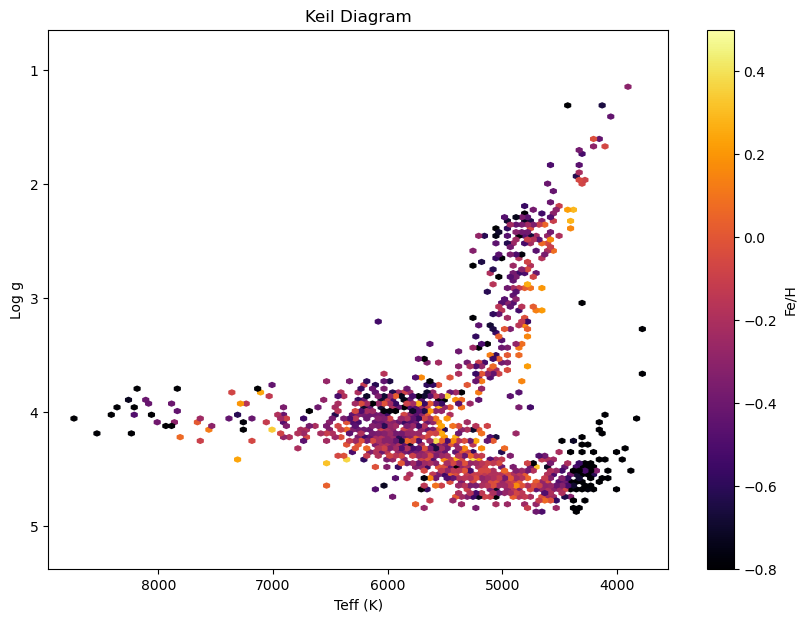

In [13]:
#Keil Diagram
fig1 = plt.figure(figsize=(10,7))
cmap = plt.cm.inferno
hb = plt.hexbin(quality_spec["TEFF"],quality_spec["LOGG"], C=quality_spec["FEH"],cmap=cmap,vmin=-0.8,vmax=0.5)
plt.colorbar(hb,label="Fe/H")
plt.xlabel("Teff (K)")
plt.ylabel("Log g")
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlim(min(quality_spec["TEFF"])-200,max(quality_spec["TEFF"])+200)
plt.ylim(min(quality_spec["LOGG"])- 0.5,max(quality_spec["LOGG"])+0.5)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title("Keil Diagram")
plt.show()

In [14]:
#Sampling the spectra
import time
sampling_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
sampled_spectras = [] #Stores the up, down or evenly sampled spectra
new_var = []
var = np.array(quality_spec["spec_error"])

def sample_data(current_spectra_flux, var, sampling_timings=[], sampled_spectras=[]): #new_sample_size is the size you set to up, down or evenly sample

    start = time.perf_counter()

    median_var = np.median(var)

    current_spectra_flux = np.array(current_spectra_flux)
    nan_mask = np.isnan(current_spectra_flux) #array of True False values of where the nan values are (True when nan value is present)
    nan_indices = np.flatnonzero(nan_mask) #gets indecies of all non zero elements (here all True elements in the mask) i.e all data that is nan
    non_nan_indices = np.flatnonzero(~nan_mask) #the ~ reverses the True False values. We now have indecies of all the data that is not nan
    current_spectra_flux[nan_indices] = np.interp(nan_indices,non_nan_indices,current_spectra_flux[non_nan_indices]) # NaN values removed

    var_change = nan_mask * (median_var * 25)
    var += var_change   

    finish = time.perf_counter()

    new_var.append(var)
    sampling_timings.append(finish-start)
    sampled_spectras.append(current_spectra_flux)

for i,spec in enumerate(quality_spec["spec"]):
    sample_data(spec,var[i],sampling_timings,sampled_spectras)

In [15]:
print("Mean Time:",str(np.mean(sampling_timings)))
print("Total Time",str(sum(sampling_timings)))

Mean Time: 0.0001170693513844071
Total Time 0.16424829999232315


In [20]:
#Implementing Boosted Median Continuum On Spectra
BMC_timings = [] #Stores the time taken to perform each BMC operation (just to check effeciency for fun)
normalized_spectra = [] #Stores the normalized spectra
continuums = [] #Stores the continuums of the spectra



def BMC(resampled_flux,window_size=50,percentile=0.98,BMC_timings=[],normalized_spectra=[],continuums=[]):

    start = time.perf_counter()

    spec_len = len(resampled_flux) 
    half_window_size = window_size//2 #We do this because the window is centered around the current value being determined. i.e index 100 will consider indecies 51-150 as part of the window
    running_stack = sorted(resampled_flux[:window_size]) #Stars as a sorted list of the first 100 
    percentile_idx = int(percentile * window_size) #Since the 
    continuum = [running_stack[percentile_idx]] * half_window_size #Because the window doesn't move until the index == half_window_size, you're still taking the nth percentile of resampled_flux[:window_size]

    for i in range(half_window_size, spec_len-half_window_size):

        #remove operation
        removal_val = resampled_flux[i-half_window_size]
        removal_idx = np.searchsorted(running_stack,removal_val) #Binary search to remove i-half_window_size value as the window has moved forward by 1
        del running_stack[removal_idx]

        #insert operation
        insertion_val = resampled_flux[i+half_window_size]
        insertion_idx = np.searchsorted(running_stack,insertion_val) #Binary search to insert the value into the running stack which is always sorted
        running_stack.insert(insertion_idx,insertion_val)

        continuum_val = running_stack[percentile_idx] 
        continuum.append(continuum_val) 

    continuum += [running_stack[percentile_idx]] * half_window_size #Window remains stationary for the last half_window_size values so we append the same value
    continuum = np.array(continuum)
    normalized = resampled_flux/continuum

    finish = time.perf_counter()
    
    BMC_timings.append(finish-start)
    normalized_spectra.append(normalized)
    continuums.append(continuum)

for resampled_flux in tqdm(sampled_spectras):
    BMC(resampled_flux,50,0.98,BMC_timings,normalized_spectra,continuums)

  0%|          | 0/1403 [00:00<?, ?it/s]

100%|██████████| 1403/1403 [00:38<00:00, 36.00it/s]


In [21]:
print("Mean Time:",str(np.mean(BMC_timings)))
print("Total Time",str(sum(BMC_timings)))

Mean Time: 0.027462198788281426
Total Time 38.52946489995884


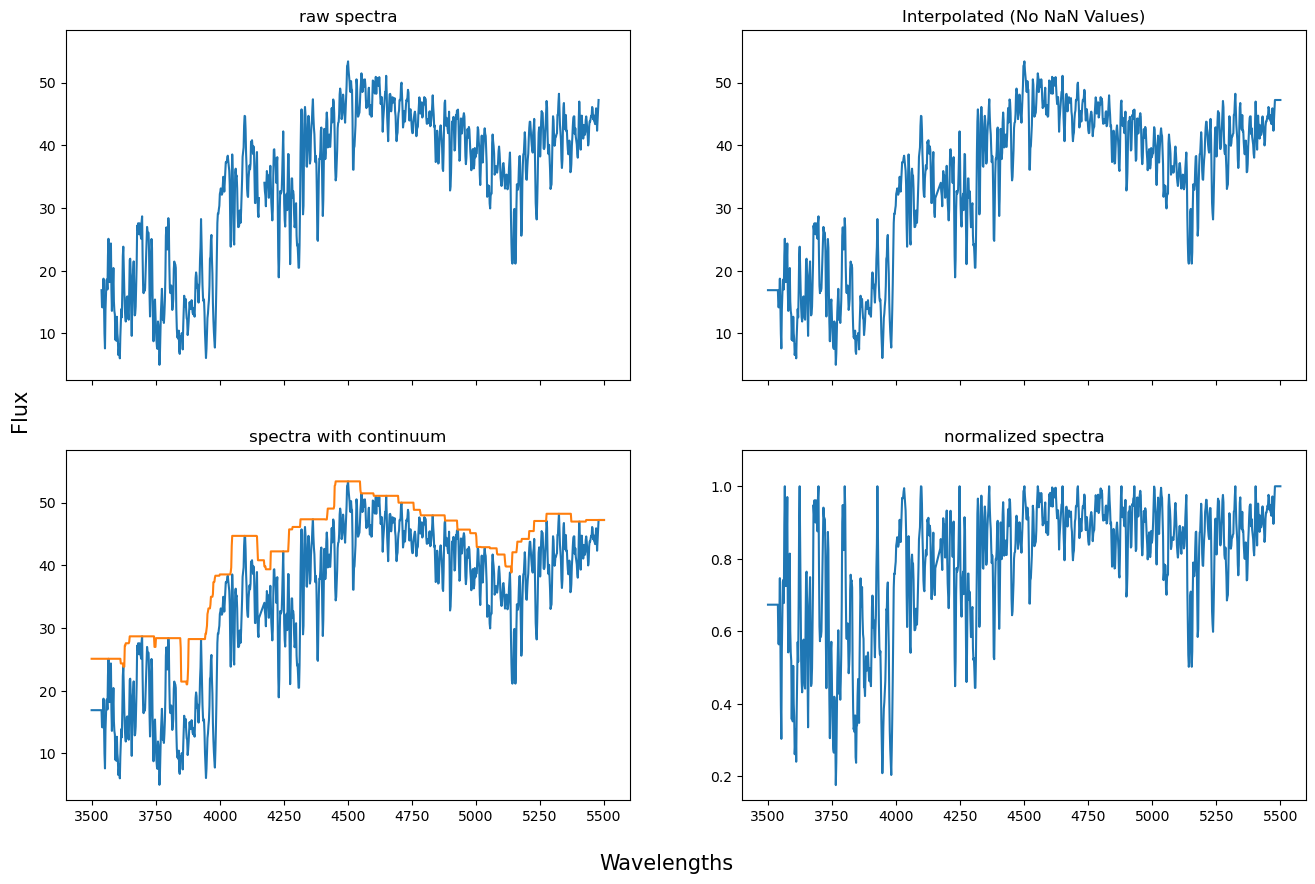

In [85]:
#Plotting graphs
idx = 0 #change this to the idx of the spectra you want to see
continuum = continuums[idx]
normalized = normalized_spectra[idx]
resampled_flux = sampled_spectras[idx]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 10),sharex=True)

ax1.plot(np.linspace(3500,5500,1036),quality_spec["spec"][idx])
ax1.set_ylim(top=max(resampled_flux)+5)
ax1.set_title("raw spectra")

ax2.plot(np.linspace(3500,5500,len(resampled_flux)),resampled_flux)
ax2.set_ylim(top=max(resampled_flux)+5)
ax2.set_title("Interpolated (No NaN Values)")

ax3.plot(np.linspace(3500,5500,len(resampled_flux)),resampled_flux)
ax3.plot(np.linspace(3500,5500,len(continuum)),continuum)
ax3.set_ylim(top=max(resampled_flux)+5)
ax3.set_title("spectra with continuum")

ax4.plot(np.linspace(3500,5500,len(normalized)),normalized)
ax4.set_ylim(top=max(normalized)+0.1)
ax4.set_title("normalized spectra")
fig.text(0.5, 0.04, 'Wavelengths', ha='center',size=15)
fig.text(0.09, 0.5, 'Flux', va='center', rotation='vertical',size=15)
plt.show()


In [9]:
#Appending the new data to the old fits file data
quality_spec.add_column(normalized_spectra,name="spec_norm")
quality_spec.add_column(continuums,name="spec_continuums")
quality_spec.add_column(sampled_spectras,name="spec_sampled")
quality_spec.add_column(new_var,name="updated_var")

In [10]:
#Saving the modified file
from astropy.io import fits
modified_data_path = os.path.join(dataset_dir,"HETVIPS_LAMOST_SPEC_UPDATED.fits")
hdu = fits.BinTableHDU(quality_spec)
hdu.writeto(modified_data_path,overwrite=True)

In [33]:
#Checking if the changes have been added
dataset_dir = "C:\\Users\\nachi\\OneDrive\\Desktop\\Hawkins Lab\\datasets"
spec_data_path = os.path.join(dataset_dir,"HETVIPS_LAMOST_SPEC_UPDATED.fits")
spec_data = Table.read(spec_data_path)
for name in sorted(spec_data.colnames):
    print(name)

ALPHA_FE
ALPHA_FE_ERR
AL_FE
AL_FE_ERR
AL_FE_FLAG
AL_FE_GRADCORR
BA_FE
BA_FE_ERR
BA_FE_FLAG
BA_FE_GRADCORR
CA_FE
CA_FE_ERR
CA_FE_FLAG
CA_FE_GRADCORR
CHI2
CHI2RATIO
CHI2RATIO_NA
CHI2_NA
CO_FE
CO_FE_ERR
CO_FE_FLAG
CO_FE_GRADCORR
CR_FE
CR_FE_ERR
CR_FE_FLAG
CR_FE_GRADCORR
CU_FE
CU_FE_ERR
CU_FE_FLAG
CU_FE_GRADCORR
C_FE
C_FE_ERR
C_FE_FLAG
C_FE_GRADCORR
DEC_1
Dec
FEH
FEH_ERR
FEH_FLAG
FEH_GRADCORR
FILENAME_2
FLAG_SINGLESTAR
LOGG
LOGG_ERR
LOGG_FLAG
LOGG_GRADCORR
MG_FE
MG_FE_ERR
MG_FE_FLAG
MG_FE_GRADCORR
MN_FE
MN_FE_ERR
MN_FE_FLAG
MN_FE_GRADCORR
NA_FE
NA_FE_ERR
NA_FE_FLAG
NA_FE_GRADCORR
NI_FE
NI_FE_ERR
NI_FE_FLAG
NI_FE_GRADCORR
N_FE
N_FE_ERR
N_FE_FLAG
N_FE_GRADCORR
O_FE
O_FE_ERR
O_FE_FLAG
O_FE_GRADCORR
ObjID_1
QFLAG_CHI2
QFLAG_CHI2NA
RA
RA_1
RV_1
RV_2
RV_ERR
SI_FE
SI_FE_ERR
SI_FE_FLAG
SI_FE_GRADCORR
SNR_DPARALLAX
SNR_G
SNR_I
SNR_R
SNR_U
SNR_Z
SPECID_1
STARID
SUBCLASS
Separation
Separation_2
TEFF
TEFF_ERR
TEFF_FLAG
TEFF_GRADCORR
TI_FE
TI_FE_ERR
TI_FE_FLAG
TI_FE_GRADCORR
UQFLAG
VMIC
VMIC_ERR
VMIC_F

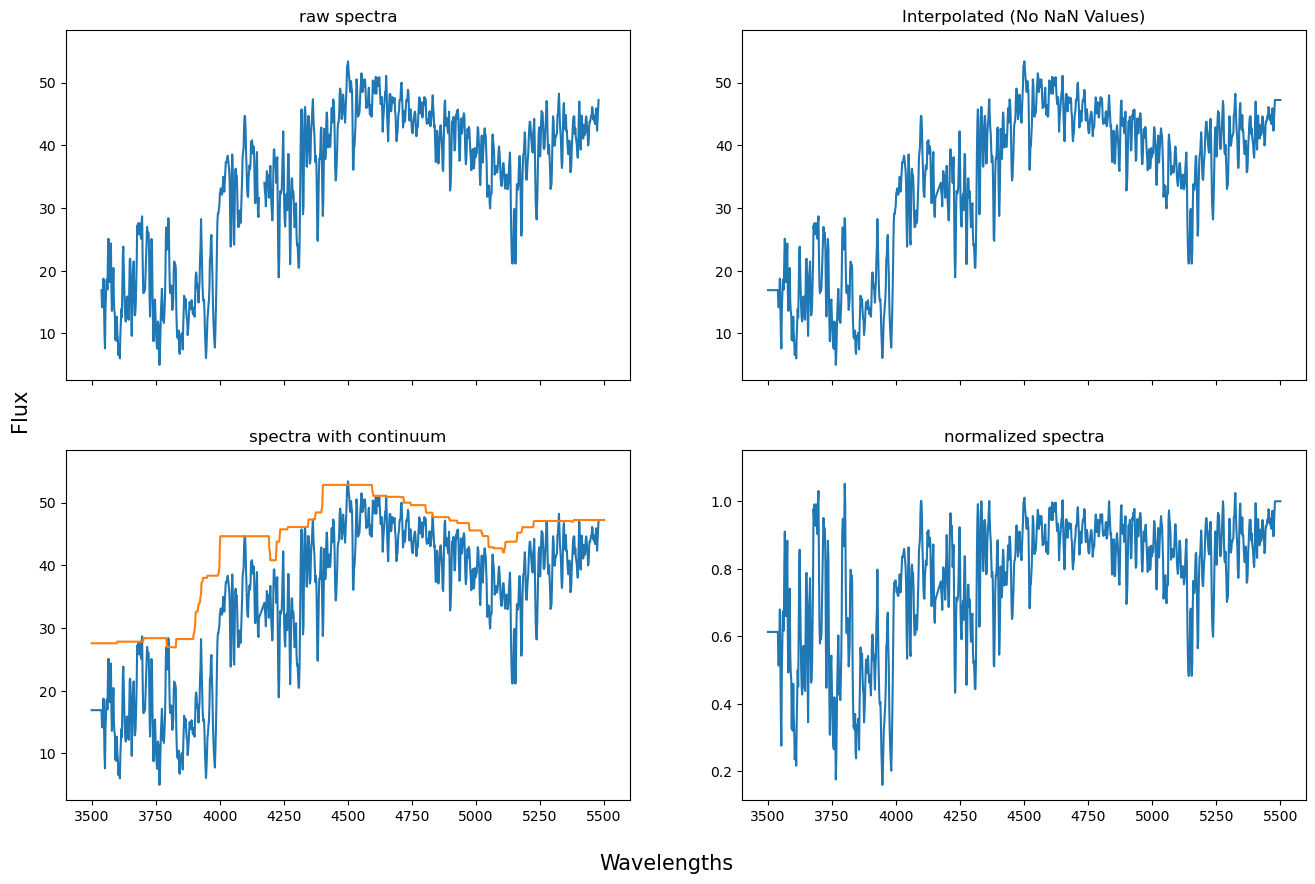

In [34]:
idx = 0
continuum = spec_data["spec_continuums"][idx]
normalized = spec_data["spec_norm"][idx]
resampled_flux = spec_data["spec_sampled"][idx]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(16, 10),sharex=True)

ax1.plot(np.linspace(3500,5500,1036),spec_data["spec"][idx])
ax1.set_ylim(top=max(resampled_flux)+5)
ax1.set_title("raw spectra")

ax2.plot(np.linspace(3500,5500,len(resampled_flux)),resampled_flux)
ax2.set_ylim(top=max(resampled_flux)+5)
ax2.set_title("Interpolated (No NaN Values)")

ax3.plot(np.linspace(3500,5500,len(resampled_flux)),resampled_flux)
ax3.plot(np.linspace(3500,5500,len(continuum)),continuum)
ax3.set_ylim(top=max(resampled_flux)+5)
ax3.set_title("spectra with continuum")

ax4.plot(np.linspace(3500,5500,len(normalized)),normalized)
ax4.set_ylim(top=max(normalized)+0.1)
ax4.set_title("normalized spectra")
fig.text(0.5, 0.04, 'Wavelengths', ha='center',size=15)
fig.text(0.09, 0.5, 'Flux', va='center', rotation='vertical',size=15)
plt.show()
